# COGS 118B Final Project
## Spectral Clustering Component
#### Group Members: Devon Rojas, Tayler Shaw, Christina Yu, Richard Duong, Efrain Contreras, Kastilla White
#### Github: https://github.com/devonrojas/COGS118B

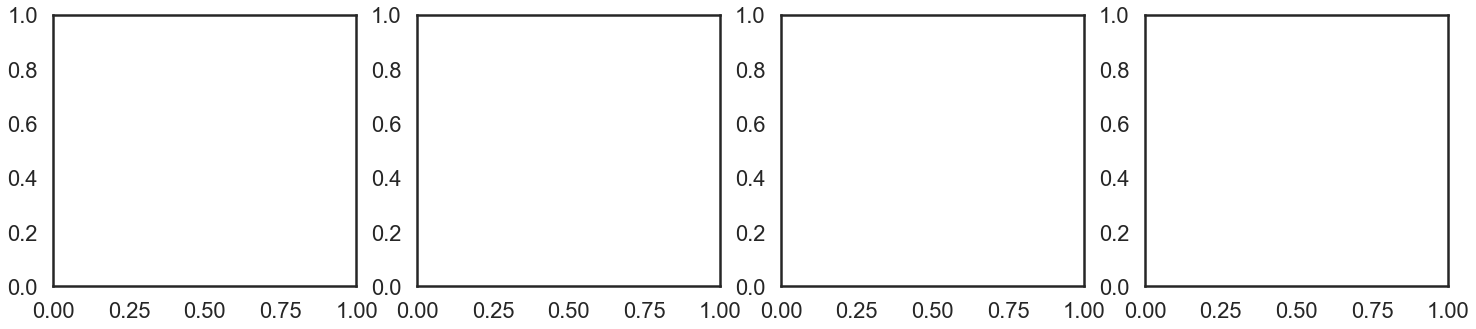

In [2]:
import numpy as np
import scipy.io as sio
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.sparse import csgraph
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

fig_nonPCA, axes_nonPCA = plt.subplots(1,4)
fig_nonPCA.set_figheight(5)
fig_nonPCA.set_figwidth(25)

In [ ]:
# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002

In [3]:
def eigsort(V, eigvals):

    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)

    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:, i] = V[:, index[i]]
    return Vsort, Dsort

## Spectral Clustering w/o PCA

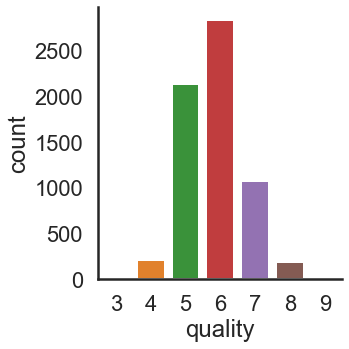

In [100]:
filenames = ['winequality-red.csv', 'winequality-white.csv']
names = ["fixed acidity",
         "volatile acidity",
         "citric acid",
         "residual sugar",
         "chlorides",
         "free sulfur dioxide",
         "total sulfur dioxide",
         "density",
         "pH",
         "sulphates",
         "alcohol",
         "quality"]

d = []
for filename in filenames:
    df = pandas.read_csv(filename, names=names, sep=";")
    d.append(df)

data = pandas.concat(d, ignore_index=True)
data_w_quality = data
data = data.drop(columns=['quality'])
sns.catplot(x='quality', data=data_w_quality, kind='count').fig.savefig('quality_hist.png')

In [127]:
# pdist(data, similarity_func)
#
# Computes the affinity value between two vectors using the euclidean
# norm squared divided by the variance of the data

# Example usage:
# dists = pdist(data, similarity_func)
def similarity_func(u, v):
    sigsq = 16
    x = u - v
    d = - (x.dot(x.T)) / (2*sigsq)
    return np.exp(d)

In [6]:
## Step 1/2: Compute affinity/similarity matrix, set diagonal entries to 0
## Set std to 40 bc 0.9 was wayyyy too small
dists = pdist(data, similarity_func)
W = pandas.DataFrame(squareform(dists), columns=list(range(0,data.shape[0])))

In [7]:
ax = axes_nonPCA[0]
ax.set_title("Affinity Matrix")
im = ax.imshow(W, extent=[0,data.shape[0],0,data.shape[0]])
fig_nonPCA.colorbar(im, ax=ax)

In [8]:
## Step 3: Computer normalized graph Laplacian
D = np.diag(np.sum(W.T, axis=0))
L = np.linalg.inv(np.sqrt(D)).dot(W).dot(np.linalg.inv(np.sqrt(D)))
vmax = np.amax(np.ndarray.max(L, axis=0))
vmin = np.amin(np.ndarray.min(L, axis=0))

ax = axes_nonPCA[1]
ax.set_title("Normalized Graph Laplacian")
im = ax.imshow(L, extent=[0, data.shape[0], 0, data.shape[0]])
im.set_clim(vmin, vmax/250) # Dividing vmax by a large enough constant to get good color on the graph
fig_nonPCA.colorbar(im, ax=ax)

In [9]:
## Step 4: Compute top k eigenvectors
num_eigvec = 2
di, X = np.linalg.eig(L)
Xsort, Dsort = eigsort(X,di)
Xuse = Xsort[:, :num_eigvec]

ax = axes_nonPCA[2]
ax.set_title("Top k Eigenvectors")
im = ax.imshow(Xuse, extent=[0, 1, 0, 1])
fig_nonPCA.colorbar(im, ax=ax)

In [10]:
## Step 5: Compute Y by normalizing X
Xsq = np.multiply(Xuse, Xuse)
divmat = repmat(np.sqrt(np.sum(Xsq.T, axis=0)).reshape(-1,1), 1, 2)
Y = np.divide(Xuse, divmat)

ax = axes_nonPCA[3]
ax.set_title("Normalized Eigenvectors")
im = ax.imshow(Y, extent=[0, 1, 0, 1])
fig_nonPCA.colorbar(im, ax=ax)

In [11]:
fig_nonPCA.tight_layout()
fig_nonPCA.savefig("Non_PCA_Spectral_Clustering.png")

In [13]:
# Step 6: Run k-means on eigenvectors 
cluster_size = num_eigvec
kmeans_nonPCA = KMeans(n_clusters=cluster_size).fit(Y)
kk_nonPCA = kmeans_nonPCA.labels_

## Because our data has dimension higher than 2, we cannot visualize the vector clusters
print("K-means results of full-dimension data:")

clusters = []
for c_num in range(0, cluster_size):
    c = data.iloc[np.argwhere(kk_nonPCA == c_num).flatten()]
    clusters.append(c)
    print("Cluster {0} => size={1}, center={2}".format(c_num+1, c.shape[0], kmeans_nonPCA.cluster_centers_[c_num]))

K-means results of full-dimension data:
Cluster 1 => size=2494, center=[ 0.64992355 -0.67582265]
Cluster 2 => size=4003, center=[0.80483135 0.49655638]


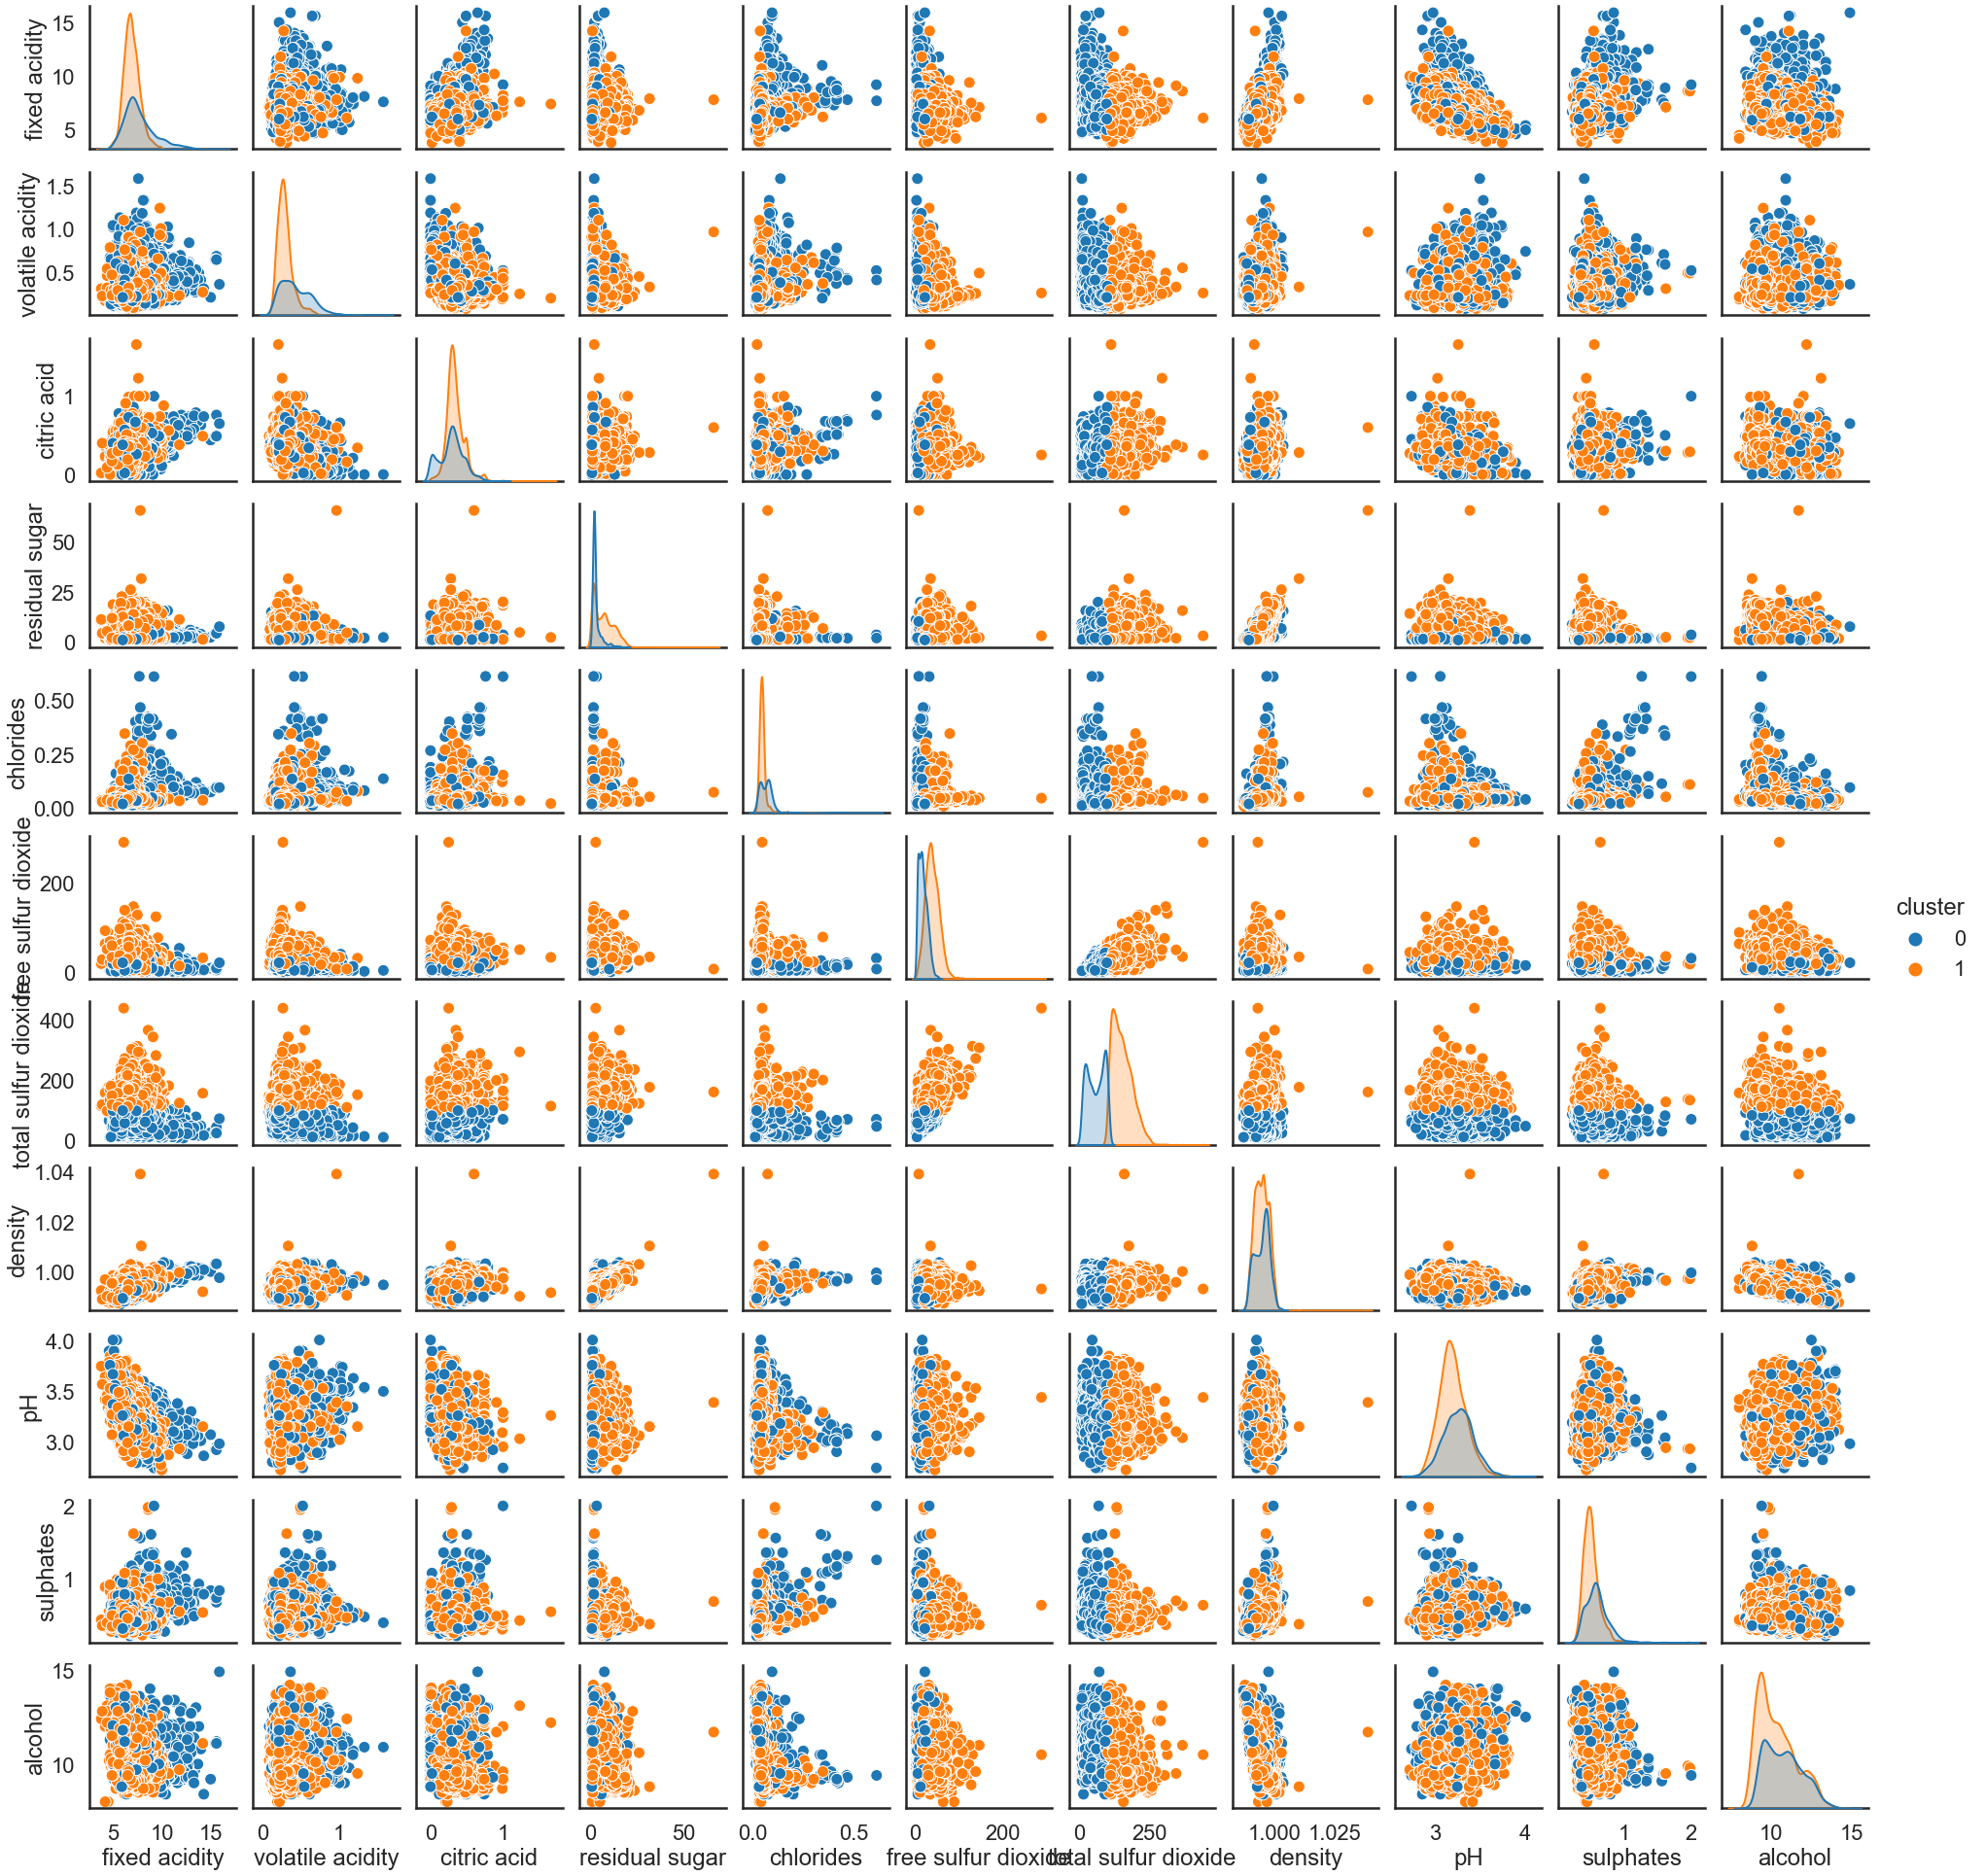

In [33]:
## Visualize spectral clustering between different attributes
data['cluster'] = kk_nonPCA
pairplot = sns.pairplot(data, hue='cluster', height=2.5)
pairplot.fig.savefig('non_PCA_pairplot.png')

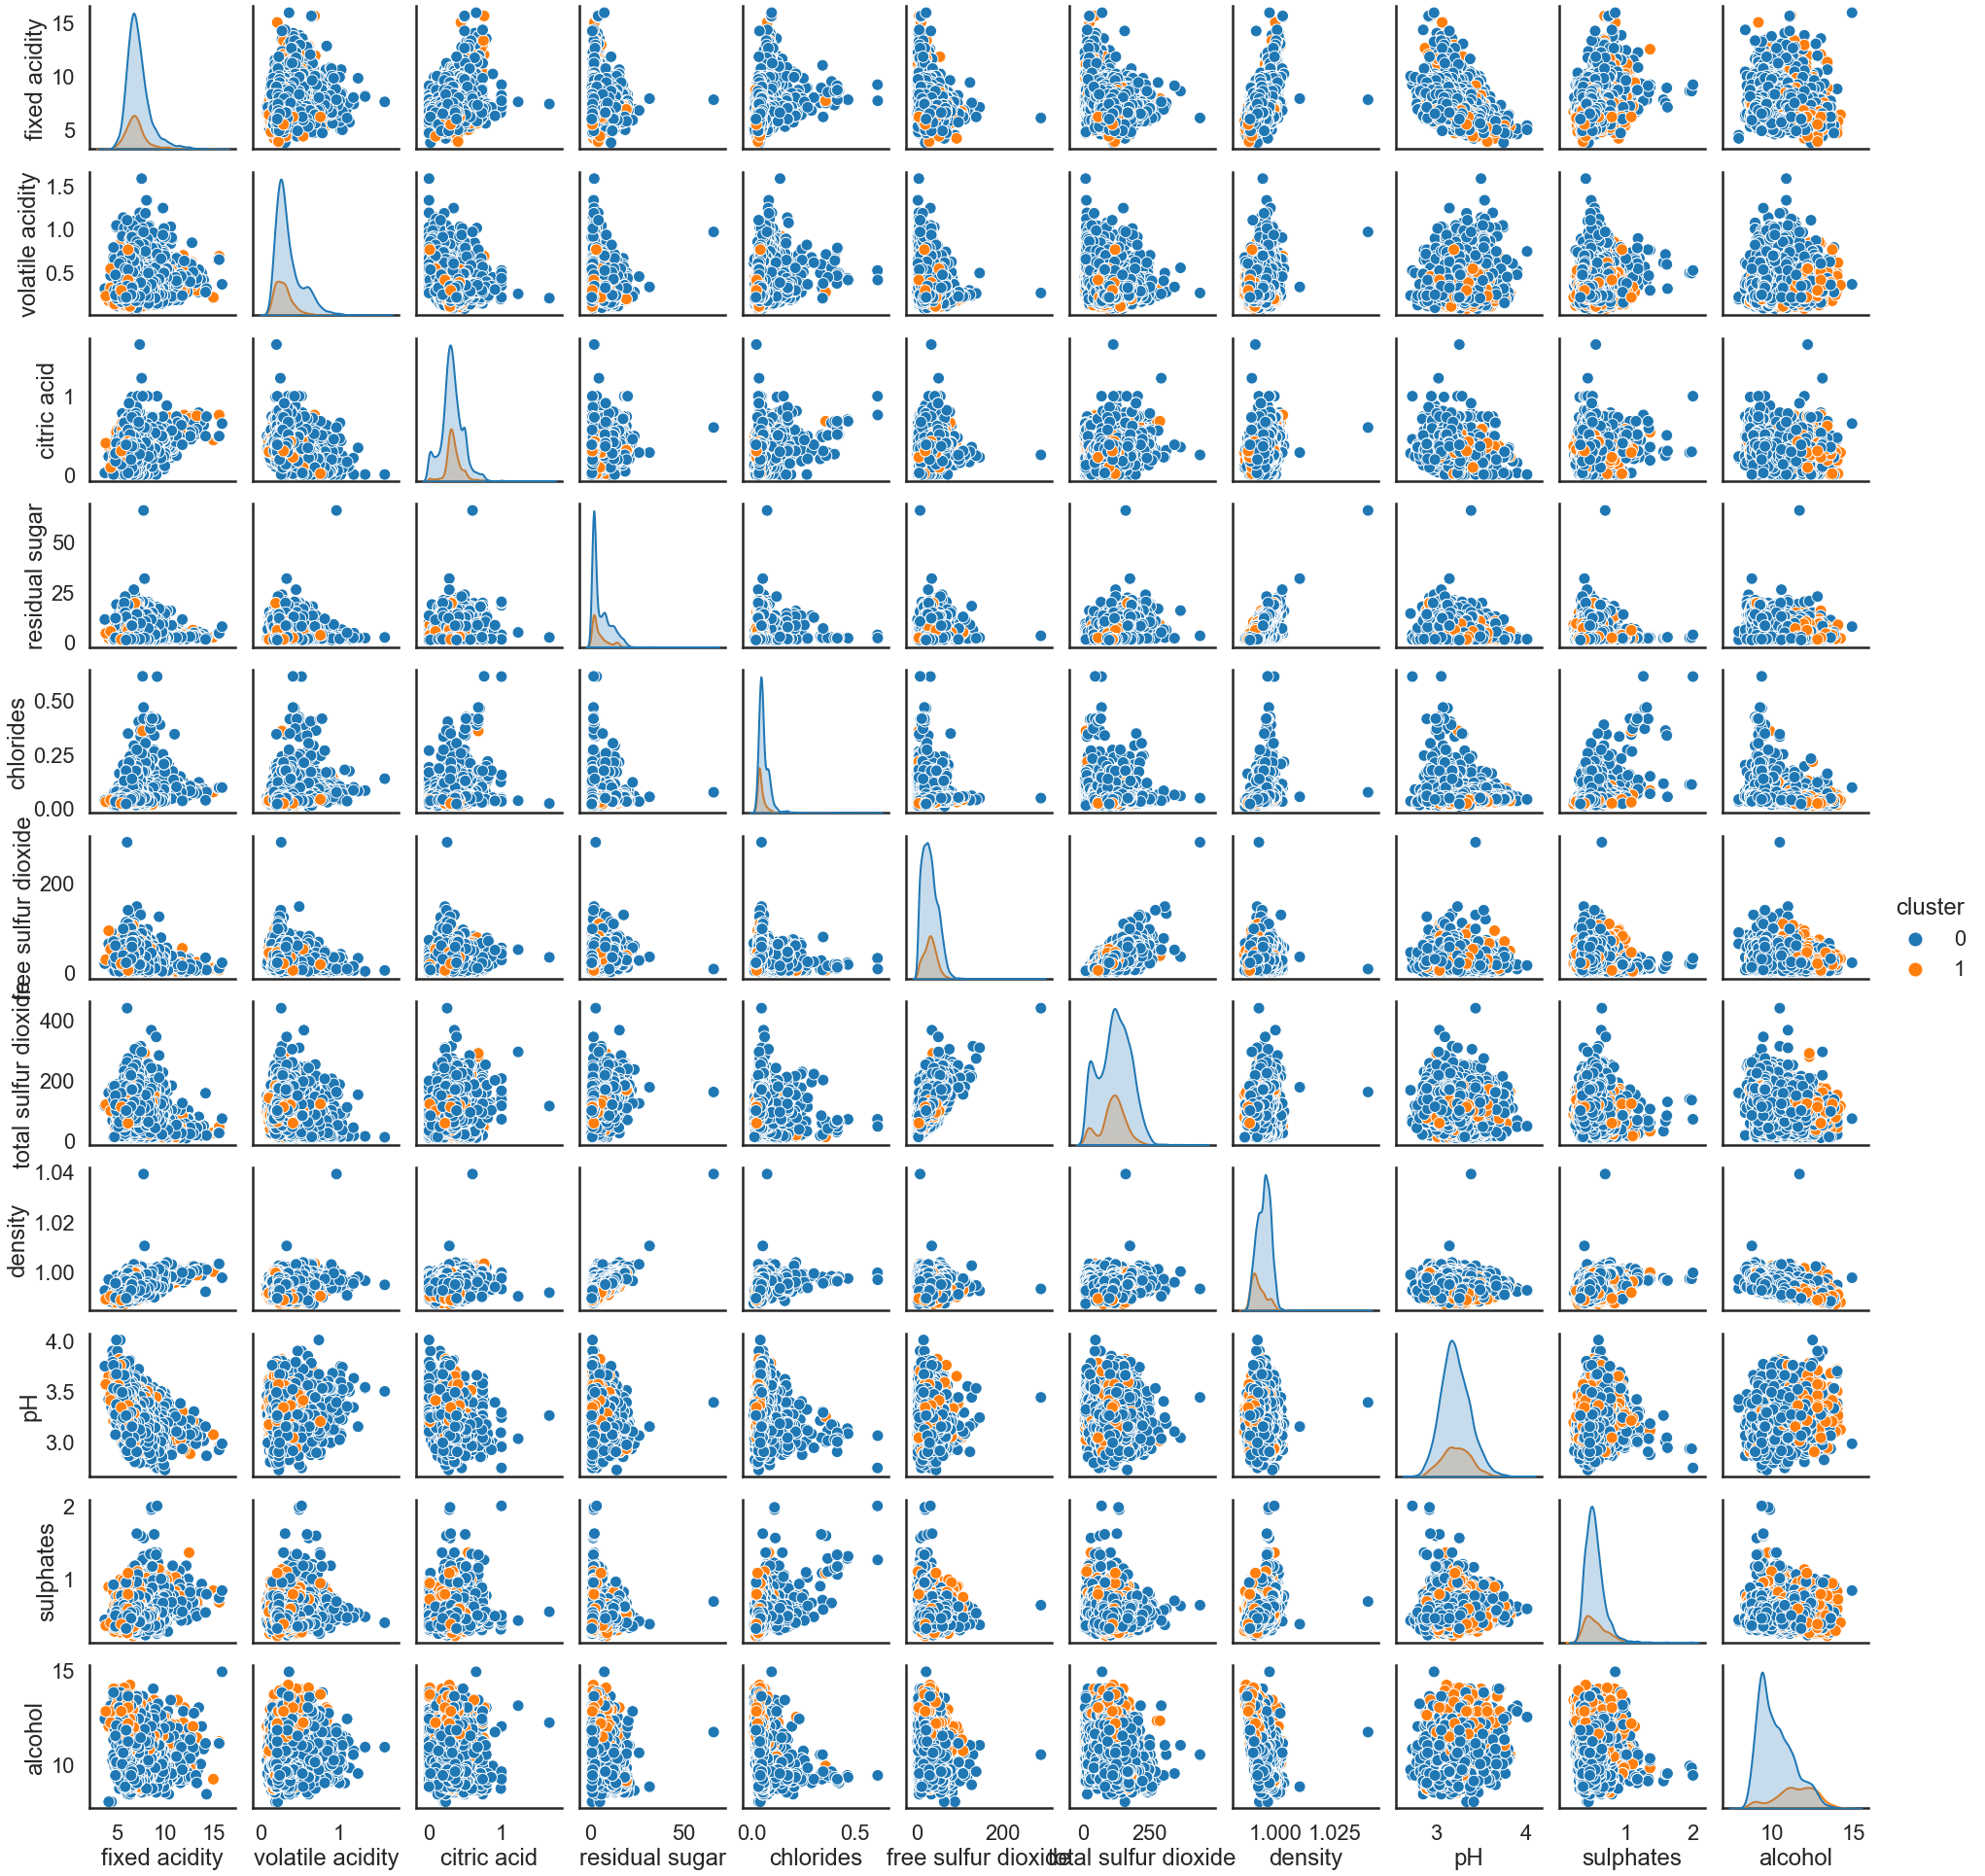

In [80]:
def quality_threshold(x):
    if x <=6:
        return 0
    else:
        return 1
    
data_w_quality['cluster'] = data_w_quality['quality'].apply(quality_threshold)
data_w_quality = data_w_quality.drop(columns=['quality'])
pairplot = sns.pairplot(data_w_quality, hue='cluster', height=2.5)
pairplot.fig.savefig('non_PCA_pairplot_quality.png')

## Spectral Clustering w/ PCA

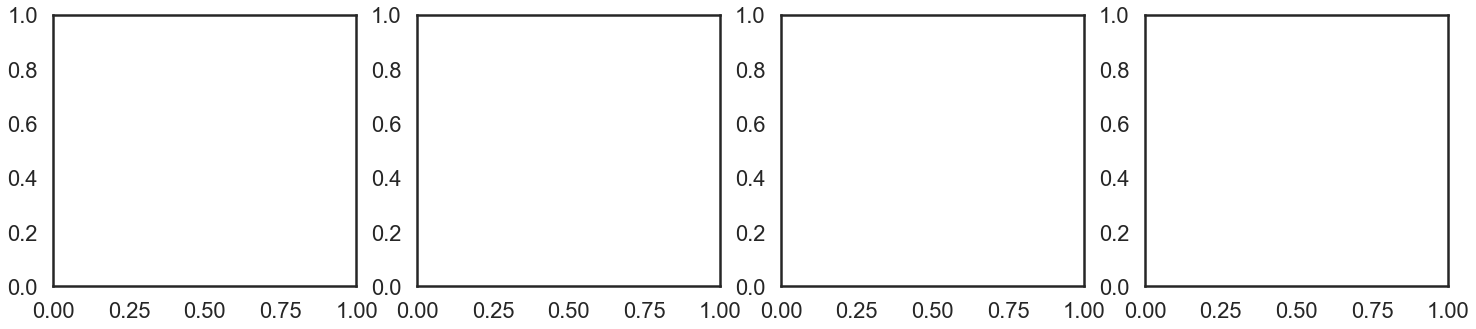

In [151]:
## Insert reg spectral clustering algorithm here and then compare cluster
## indices with cluster indicies from above to see the similarities
filename = "4_PCA.csv"
data2 = pandas.read_csv(filename)
goto = np.shape(data2)[0]

fig_PCA, axes_PCA = plt.subplots(1,4)
fig_PCA.set_figheight(5)
fig_PCA.set_figwidth(25)
data2 = data2.drop(columns=['Quality', 'Unnamed: 0'])

In [160]:
## Step 1/2: Compute affinity/similarity matrix, set diagonal entries to 0
## Set std to 40 bc 0.9 was wayyyy too small
dists = pdist(data2, similarity_func)
W = pandas.DataFrame(squareform(dists), columns=list(range(0,data2.shape[0])))

In [161]:
W.head()

0         1         2         3         4         5         6     \
0  0.000000  0.970385  0.963447  0.345011  1.000000  0.998337  0.914177   
1  0.970385  0.000000  0.995418  0.458966  0.970385  0.971908  0.937322   
2  0.963447  0.995418  0.000000  0.489962  0.963447  0.965691  0.951849   
3  0.345011  0.458966  0.489962  0.000000  0.345011  0.357673  0.501979   
4  1.000000  0.970385  0.963447  0.345011  0.000000  0.998337  0.914177   

       7         8         9     ...      6487      6488      6489      6490  \
0  0.935385  0.964794  0.691911  ...  0.404514  0.404172  0.383836  0.379892   
1  0.896553  0.974880  0.780869  ...  0.463464  0.441257  0.396956  0.391741   
2  0.915966  0.987613  0.796822  ...  0.488577  0.450612  0.434083  0.418606   
3  0.376329  0.466804  0.701484  ...  0.627095  0.415756  0.441480  0.397965   
4  0.935385  0.964794  0.691911  ...  0.404514  0.404172  0.383836  0.379892   

       6491      6492      6493      6494      6495      6496  
0  0.470534  0.457006  0.357086  0.465017  0.331706  0.306209  
1  0.507745  0.469608  0.404965  0.503078  0.317207  0.310086  
2  0.536105  0.505684  0.414172  0.531603  0.349040  0.341871  
3  0.544248  0.465097  0.461872  0.530201  0.279049  0.347343  
4  0.470534  0.457006  0.357086  0.465017  0.331706  0.306209  

[5 rows x 6497 columns]

In [162]:
ax = axes_PCA[0]
ax.set_title("Affinity Matrix")
im = ax.imshow(W, extent=[0,data2.shape[0],0,data2.shape[0]])
fig_PCA.colorbar(im, ax=ax)

In [163]:
## Step 3: Computer normalized graph Laplacian
D = np.diag(np.sum(W.T, axis=0))
L = np.linalg.inv(np.sqrt(D)).dot(W).dot(np.linalg.inv(np.sqrt(D)))
vmax = np.amax(np.ndarray.max(L, axis=0))
vmin = np.amin(np.ndarray.min(L, axis=0))

ax = axes_PCA[1]
ax.set_title("Normalized Graph Laplacian")
im = ax.imshow(L, extent=[0, data2.shape[0], 0, data2.shape[0]])
im.set_clim(vmin, vmax/80) # Dividing vmax by a large enough constant to get good color on the graph
fig_PCA.colorbar(im, ax=ax)

In [164]:
## Step 4: Compute top k eigenvectors
num_eigvec = 2
di, X = np.linalg.eig(L)
Xsort, Dsort = eigsort(X,di)
Xuse = Xsort[:, :num_eigvec]

ax = axes_PCA[2]
ax.set_title("Top k Eigenvectors")
im = ax.imshow(Xuse, extent=[0, 1, 0, 1])
fig_PCA.colorbar(im, ax=ax)

In [133]:
## Step 5: Compute Y by normalizing X
Xsq = np.multiply(Xuse, Xuse)
divmat = repmat(np.sqrt(np.sum(Xsq.T, axis=0)).reshape(-1,1), 1, 2)
Y = np.divide(Xuse, divmat)

ax = axes_PCA[3]
ax.set_title("Normalized Eigenvectors")
im = ax.imshow(Y, extent=[0, 1, 0, 1])
fig_PCA.colorbar(im, ax=ax)

In [156]:
fig_PCA.tight_layout()
fig_PCA.savefig("PCA_Spectral_Clustering.png")

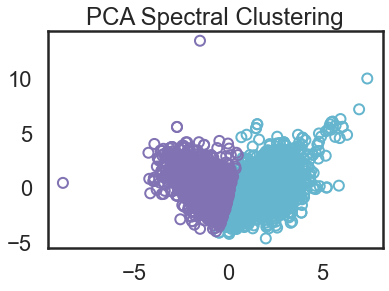

In [157]:
# step 5/6
kmeans = KMeans(n_clusters=2).fit(Y)
kk_PCA = kmeans.labels_
c1 = np.argwhere(kk_PCA == 0).flatten()
c2 = np.argwhere(kk_PCA == 1).flatten()

plt.scatter(data2.iloc[c1].iloc[:,0], data2.iloc[c1].iloc[:,1], edgecolor='c', marker='o', facecolor='none', s=100)
plt.scatter(data2.iloc[c2].iloc[:,0], data2.iloc[c2].iloc[:,1], edgecolor='m', marker='o', facecolor='none', s=100)
plt.title('PCA Spectral Clustering')
plt.savefig("Kmeans_withPCA.png")

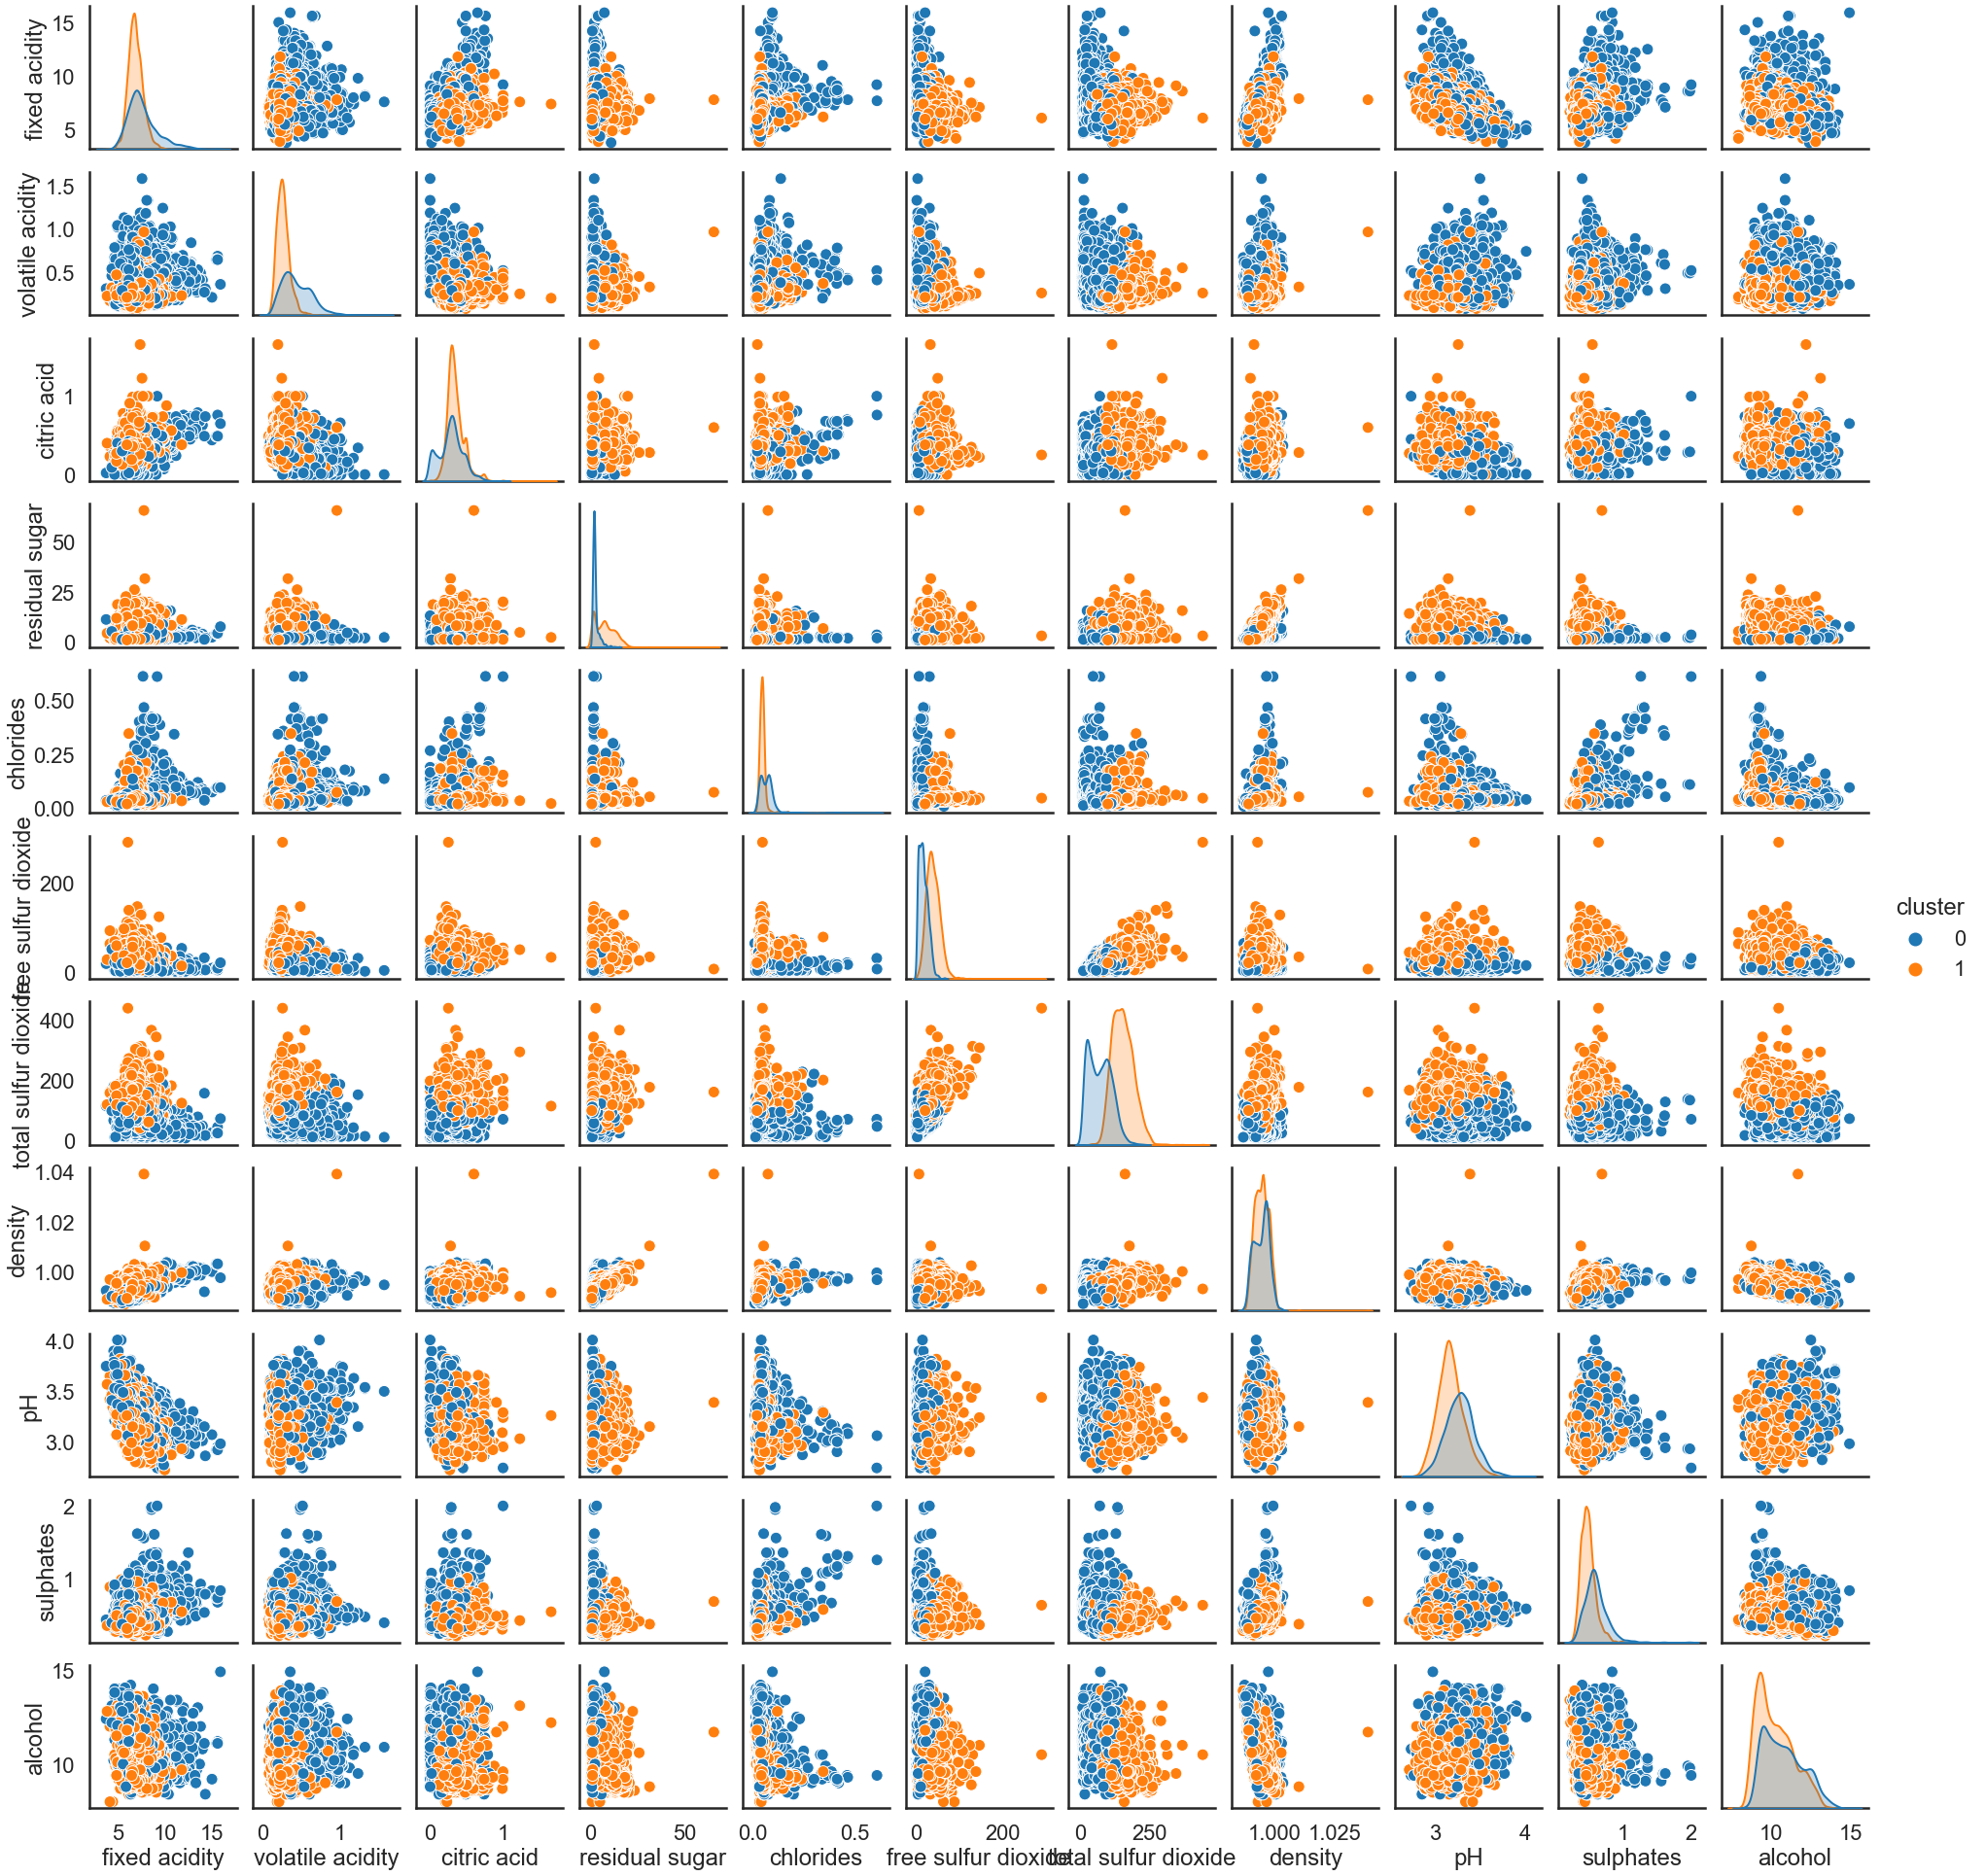

In [158]:
data['cluster'] = kk_PCA
pairplot = sns.pairplot(data, hue='cluster', height=2.5)
pairplot.fig.savefig('PCA_pairplot_4.png')

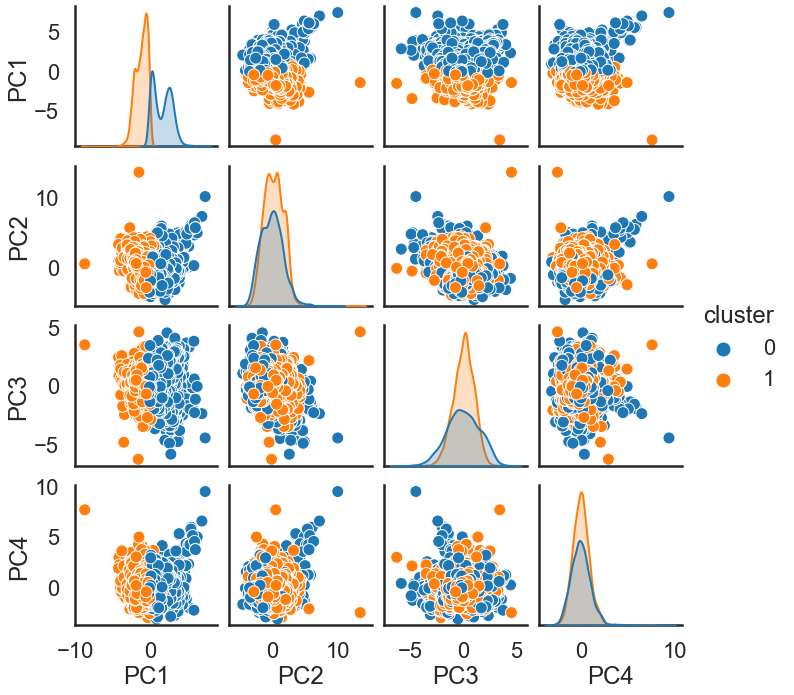

In [159]:
data2['cluster'] = kk_PCA
pairplot = sns.pairplot(data2, hue='cluster', height=2.5)
pairplot.fig.savefig('PCA_pairplot_4com.png')